In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

data = pd.read_csv('couples.csv', sep = ',',na_values = '.', decimal = '.', encoding =  'utf-8')


A FAIRE: 
- variable c'est l'homme qui a le soucis, c'est la femme qui a le soucis, les deux ont un soucis
- Durée entre la première consultation et la date de conception pour ceux ayant eu un enfant
- Durée entre la première consultation et la date des dernières nouvelles (01/06/2009)
- Encadrement de l'âge
- Encadrement de l'indice de masse corporelle
- Encadrement de la durée d'infertilité avant consultation

In [335]:
data.head()

,id,enfant,dconsultation,dconception,ddn,age_h,diplome_h,bmi_h,patho_h,cryptorchidie,spermo,age_f,diplome_f,bh_f,ct_f,patho_f,fecondite,duree_infertilite,traitement
0,2707,1,18/04/2000,22/01/2001,NaN,33,Bac+,27.166448,non,Non,normal,34.0,Bac+,normal,ovulation,non,primaire,38.0,IAC
1,2955,1,11/03/2003,14/03/2007,NaN,42,Bac-,22.204082,non,Non,anormal,30.0,Bac,normal,ovulation,NaN,primaire,16.0,ICSI
2,3801,1,24/08/2004,05/10/2005,NaN,45,Bac+,26.794938,non,Non,anormal,29.0,Bac+,NaN,NaN,NaN,secondaire,10.0,IAC
3,5816,0,17/04/2001,NaN,01/06/2009,36,Bac+,18.612245,non,Non,anormal,38.0,Bac+,normal,ovulation,pb tubaire unilateral,secondaire,60.0,FIV
4,12933,0,18/08/2004,NaN,01/06/2009,32,Bac,24.158818,non,Non,azoo,30.0,Bac+,NaN,NaN,NaN,secondaire,6.0,Medical


On va séparer les données numériques des données catégorielles


In [336]:
data.dtypes


id                     int64
enfant                 int64
dconsultation         object
dconception           object
ddn                   object
age_h                  int64
diplome_h             object
bmi_h                float64
patho_h               object
cryptorchidie         object
spermo                object
age_f                float64
diplome_f             object
bh_f                  object
ct_f                  object
patho_f               object
fecondite             object
duree_infertilite    float64
traitement            object
dtype: object

In [337]:
data.isnull().sum()

id                     0
enfant                 0
dconsultation          0
dconception          494
ddn                  637
age_h                  0
diplome_h              3
bmi_h                 22
patho_h                0
cryptorchidie          0
spermo                 0
age_f                  3
diplome_f             22
bh_f                 359
ct_f                 355
patho_f              368
fecondite              0
duree_infertilite      0
traitement             0
dtype: int64

Pour dconsultation et ddn c'est normal car un couple à une dconception ssi il a eu un enfant et une ddn sinon
Pour diplome_h, bmi_h, age_f, diplome_f comme il n'y a que peu de valeur manquante, on peut les remplacer par la catégorie la plus commune.

Pour bh_f, ct_f et patho_f, on va décider dans un premier temps de créer une nouvelle catégorie attribué aux valeur manquantes, comme cela, si une logique existe derrière ces na, le modèle en tiendra compte

Pourquoi des valeurs sont na? Principalement sur la femme

Hypothèse: 
- Le traitement doit nous donner un indice
- La présence presque automatique d'un problème chez l'homme lorsque la femme a des NA nous permet de supposer que le variable a été laissé vide, c'est à dire que tout est normal

In [338]:
###
#  Remplacer par la catégorie la plus fréquente dans le cas d'une catégorie et la moyenne sinon
###

#diplome_h
data.diplome_h = data.diplome_h.fillna(data['diplome_h'].value_counts().index[0])

#bmi_h
data.bmi_h = data.bmi_h.fillna(data['bmi_h'].mean())

#age_f
data.age_f = data.age_f.fillna(data['age_f'].mean())

#diplome_f
data.diplome_f = data.diplome_f.fillna(data['diplome_f'].value_counts().index[0])

In [339]:
###
#  Remplacer par un niveau NA
###

#bh_f
data.bh_f= data.bh_f.fillna('NA')

#ct_f
data.ct_f = data.ct_f.fillna('NA')

#patho_f
data.patho_f = data.patho_f.fillna('NA')

In [340]:
data['diplome_h'].value_counts()

Bac+    495
Bac-    451
Bac     185
Name: diplome_h, dtype: int64

In [341]:
list(set(data.bh_f))

['anormal', 'NA', 'normal']

## Recodage des Données

### Facteur avec que deux catégories en binaire

In [342]:
dic = {
    'Oui' : 1,
    'Non' : 0
}
data.cryptorchidie = data.cryptorchidie.map(dic)


### Age en catégorie

In [343]:
data['tranche_age_h'] = pd.cut(data.age_h, bins = [data.age_h.min(),30,40,50,data.age_h.max()], labels = ['- 30 ans','30 à 40 ans', \
                                                                                       '40 à 50 ans','+ 50 ans'])
data['tranche_age_f'] = pd.cut(data.age_f, bins = [16,30,40,data.age_f.max()], labels = ['- 30 ans','30 à 40 ans', \
                                                                                       '+ 40 ans'])

### Indice de masse corporelle en interprétation (source: Wikipedia)

In [344]:
#Commentaire: ne pas mettre -1 crée un problème, le minimum ne rentre pas dans une tranche et devient un NA
data['tranche_bmi_h'] = pd.cut(data.bmi_h, \
                              bins = [data.bmi_h.min() - 1 ,16.5,18.5,25,30,data.bmi_h.max() +1],\
                              labels = ['Denutrition ou anorexie','Maigreur', 'Corpulence normale',\
                                       'Surpoid', 'Obesite'])

In [345]:
data.tranche_bmi_h.isnull().any()

False

### Encadrement de la durée d'infertilité avant la première consultation

Regardons d'abord la répartition avant de créer des catégories

In [346]:

data.duree_infertilite.quantile([0.25,0.5,0.75])

0.25    18.0
0.50    24.0
0.75    36.0
Name: duree_infertilite, dtype: float64

In [347]:
data['tranche_duree_infertilite'] = pd.cut(data.duree_infertilite, \
                              bins = [data.duree_infertilite.min(),6,12,24,data.duree_infertilite.max()],\
                              labels = ['- 6 mois','6-12 mois', '1-2 ans','+ 2ans'])

In [348]:
data.head()

,id,enfant,dconsultation,dconception,ddn,age_h,diplome_h,bmi_h,patho_h,cryptorchidie,...,bh_f,ct_f,patho_f,fecondite,duree_infertilite,traitement,tranche_age_h,tranche_age_f,tranche_bmi_h,tranche_duree_infertilite
0,2707,1,18/04/2000,22/01/2001,NaN,33,Bac+,27.166448,non,0,...,normal,ovulation,non,primaire,38.0,IAC,30 à 40 ans,30 à 40 ans,Surpoid,+ 2ans
1,2955,1,11/03/2003,14/03/2007,NaN,42,Bac-,22.204082,non,0,...,normal,ovulation,NA,primaire,16.0,ICSI,40 à 50 ans,- 30 ans,Corpulence normale,1-2 ans
2,3801,1,24/08/2004,05/10/2005,NaN,45,Bac+,26.794938,non,0,...,NA,NA,NA,secondaire,10.0,IAC,40 à 50 ans,- 30 ans,Surpoid,6-12 mois
3,5816,0,17/04/2001,NaN,01/06/2009,36,Bac+,18.612245,non,0,...,normal,ovulation,pb tubaire unilateral,secondaire,60.0,FIV,30 à 40 ans,30 à 40 ans,Corpulence normale,+ 2ans
4,12933,0,18/08/2004,NaN,01/06/2009,32,Bac,24.158818,non,0,...,NA,NA,NA,secondaire,6.0,Medical,30 à 40 ans,- 30 ans,Corpulence normale,- 6 mois


### Gestion des dates / Durée entre la première consultation et la date de conception pour ceux ayant eu un enfant

In [349]:
data.dconsultation = pd.to_datetime(data.dconsultation)
data.dconception = pd.to_datetime(data.dconception)
data.ddn = pd.to_datetime(data.ddn)

Si nous voulons étudier, ou plutot prédire si les individus ont eu des enfants après la ddn (dans le cas ou la première consultation à eu lieu peu avant), il nous faut connaitre les durée entre traitement et consultation

In [350]:
data['delta_consult_concep'] = (data.dconception - data.dconsultation)/np.timedelta64(1, 'M')
data['delta_consult_ddn'] = (data.ddn - data.dconsultation)/np.timedelta64(1, 'M')
data['duree_totale_du_programme'] = [i if not np.isnan(i) else j for i,j in zip(data['delta_consult_concep'],data['delta_consult_ddn'])]

In [351]:
#Certaine date de conception sont antérieures à la date de la conultation. Il s'agit de données abérrantes, 
#il faudra les supprimer
data.duree_totale_du_programme[32]

-0.59138791350951769

### Recodage pathologie

In [352]:
dico = {'non': 'non',
 'chimiotherapie': 'chimiotherapie',
 'neurologique' : 'probleme neurologique',
 'hodgkin , chimiotherapie , radiotherapie': 'chimiotherapie',
 'sinusites chroniques' : 'probleme respiratoire',
 'sarcome , chimiotherapie': 'chimiotherapie',
 'cancer testis , chimiotherapie' : 'chimiotherapie',
 'pathologies respiratoire chroniques': 'probleme respiratoire',
 'sinusites chroniques , pathologies respiratoire chroniques': 'probleme respiratoire',
 'chimiotherapie , radiotherapie' : 'chimiotherapie',
 'autre' : 'autre',
 'diabete' : 'diabete'}
data.patho_h = data.patho_h.map(dico)



In [353]:
dicoIsPathoH = {elem:0 if elem == 'non' else 1 for elem in list(set(data.patho_h))}

catPathoF = list(set(data.patho_f))
catPathoF = [x for x in catPathoF if str(x) != 'nan']


dicoIsPathoF = {elem:0 if elem == 'non' else 1 for elem in catPathoF}

data['isPathoH'] = data.patho_h.map(dicoIsPathoH)
data['isPathoF'] = data.patho_f.map(dicoIsPathoF)




In [354]:
list(set(data.spermo))

['azoo', 'anormal', 'normal']

Présence d'un problème chez l'homme et chez la femme

In [355]:
# L'homme a t'il un problème de santé impactant sa fécondité? Idem pour la femme

pbFemme = [1 if (pat == 1) | (ct == 'dysovulation') | (ct == 'anovulation') | (bh=='anormal') \
           else 0 for (ct,pat,bh) in zip(data.ct_f, data.isPathoF, data.bh_f)]
data['pb_F'] = pbFemme

pbHomme = [1 if (pat == 1) | (cr == 1) | (sp == 'azoo') | (sp=='anormal') \
           else 0 for (cr,pat,sp) in zip(data.cryptorchidie, data.isPathoH, data.spermo)]
data['pb_H'] = pbHomme

data['pb_H_et_F'] = data['pb_F'] * data['pb_H']

In [356]:
data.pb_H_et_F.mean()

0.4588859416445623

In [357]:
categorical_features = data.dtypes.index[(data.dtypes == 'object') | (data.dtypes == 'category')] 
numerical_features = data.dtypes.index[data.dtypes != 'object']
numerical_features = [f for f in numerical_features if f not in ['id','enfant'] ] #Remove the target and the id
target = data.enfant
numerical_data = data[numerical_features]
categorical_data = data[categorical_features]
print('Le jeu de donnée est constitué de ' + str(data.shape[0]) + ' enregistrements comportant ' + str(data.shape[1]) + \
      ' variables numériques et '+ str(categorical_data.shape[1])+ ' variables catégorielles.')

Le jeu de donnée est constitué de 1131 enregistrements comportant 31 variables numériques et 13 variables catégorielles.


## Description de la population étudiée

### Variables numériques

In [358]:
numerical_data.describe()

,age_h,bmi_h,cryptorchidie,age_f,duree_infertilite,delta_consult_concep,delta_consult_ddn,duree_totale_du_programme,isPathoH,isPathoF,pb_F,pb_H,pb_H_et_F
count,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,637.000000,494.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000
mean,33.692308,24.821211,0.139699,30.949468,31.540937,20.170010,77.847653,45.362544,0.255526,0.427940,0.564987,0.832891,0.458886
std,5.867785,3.450065,0.346828,4.445154,22.587268,15.996864,18.058992,33.247838,0.436349,0.494999,0.495978,0.373238,0.498527
min,18.000000,11.830719,0.000000,16.000000,1.000000,-9.495062,48.329534,-9.495062,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,22.652451,0.000000,28.000000,18.000000,8.509415,60.518696,14.587569,0.000000,0.000000,0.000000,1.000000,0.000000
50%,33.000000,24.441802,0.000000,31.000000,24.000000,17.281669,79.295263,40.378653,0.000000,0.000000,1.000000,1.000000,0.000000
75%,37.000000,26.234568,0.000000,34.000000,36.000000,29.306557,93.012177,74.350603,1.000000,1.000000,1.000000,1.000000,1.000000
max,61.000000,54.143211,1.000000,47.000000,168.000000,88.412493,108.125424,108.125424,1.000000,1.000000,1.000000,1.000000,1.000000


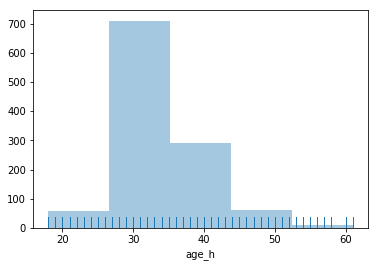

In [359]:
%matplotlib inline
sns.distplot(data.age_h, bins=5, kde=False, rug=True)

### Variables catégorielles

In [360]:
def barplot_percentage(varName, data, title,ax=None):
    total = float(len(data))
    ax = sns.countplot(x=varName, data=data,ax = ax ) # for Seaborn version 0.7 and more
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 20,
                '{:1.2f} %'.format(height/total*100),
                ha="center") 
    ax.set_title(title)
    ax.set(ylim=(0, 800))


#### Données socio-démographique


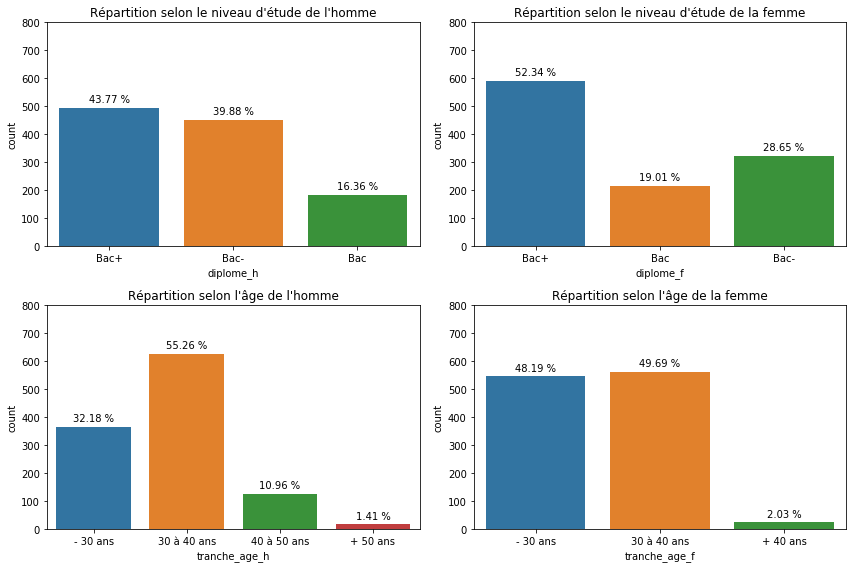

In [361]:
fig, axs = plt.subplots(ncols=2,nrows = 2, figsize=(12,8))

barplot_percentage('diplome_h', data, 'Répartition selon le niveau d\'étude de l\'homme', ax = axs[0,0])
barplot_percentage('diplome_f', data, 'Répartition selon le niveau d\'étude de la femme', ax = axs[0,1])
barplot_percentage('tranche_age_h', data, 'Répartition selon l\'âge de l\'homme', ax = axs[1,0])
barplot_percentage('tranche_age_f', data, 'Répartition selon l\'âge de la femme', ax = axs[1,1])
fig.tight_layout()

#### Etat de santé 

Plusieurs variables indiquent l'état de santé des couples:
- Indice de masse corporel
- Pathologie/problèmes de santé chez l'homme et la femme
- Cryptorchidie chez l'homme
- Spectrogramme chez l'homme
- Bilan hormonal de la femme
- Ovulation de la femme

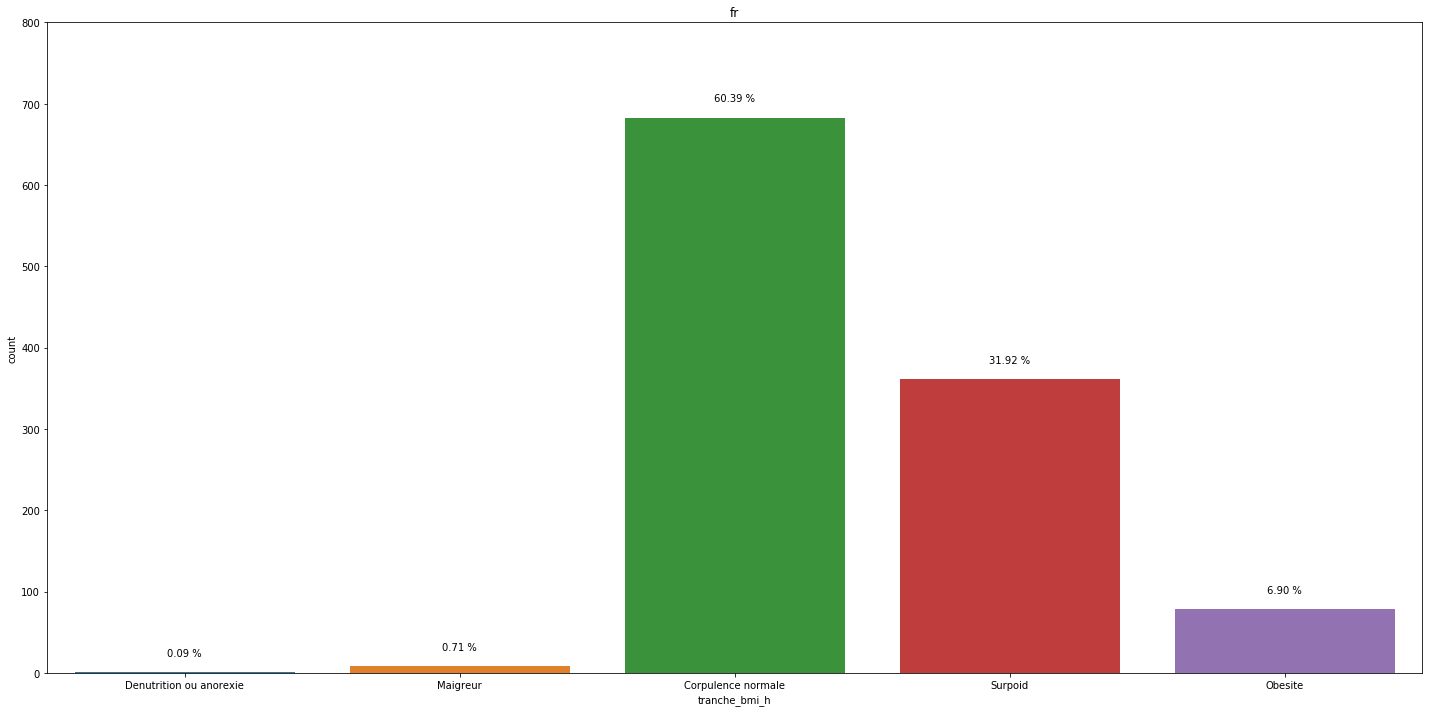

In [362]:
#data.tranche_bmi_h = data.tranche_bmi_h.fillna('Denutrition ou anorexie')
plt.figure(figsize=(20,10))
barplot_percentage('tranche_bmi_h', data, 'fr')
plt.tight_layout()




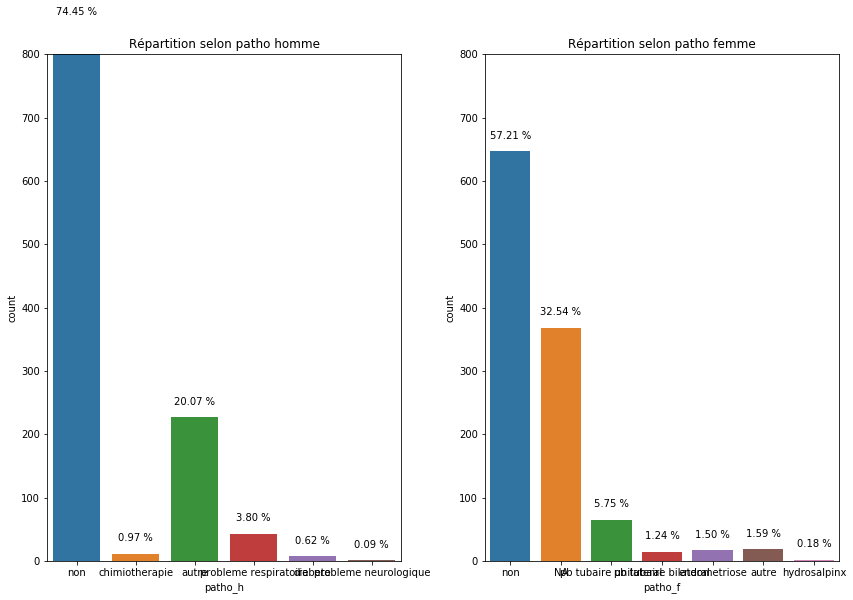

In [363]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8))
barplot_percentage('patho_h', data, 'Répartition selon patho homme', ax = axs[0])
barplot_percentage('patho_f', data, 'Répartition selon patho femme', ax = axs[1])
fig.tight_layout()

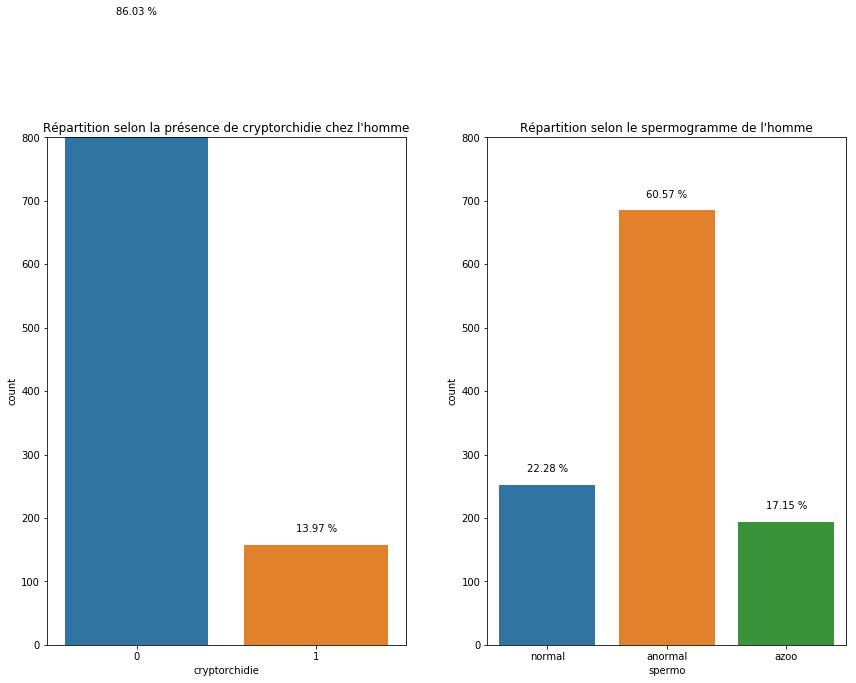

In [364]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8))
barplot_percentage('cryptorchidie', data, 'Répartition selon la présence de cryptorchidie chez l\'homme', ax = axs[0])
barplot_percentage('spermo', data, 'Répartition selon le spermogramme de l\'homme', ax = axs[1])
fig.tight_layout()

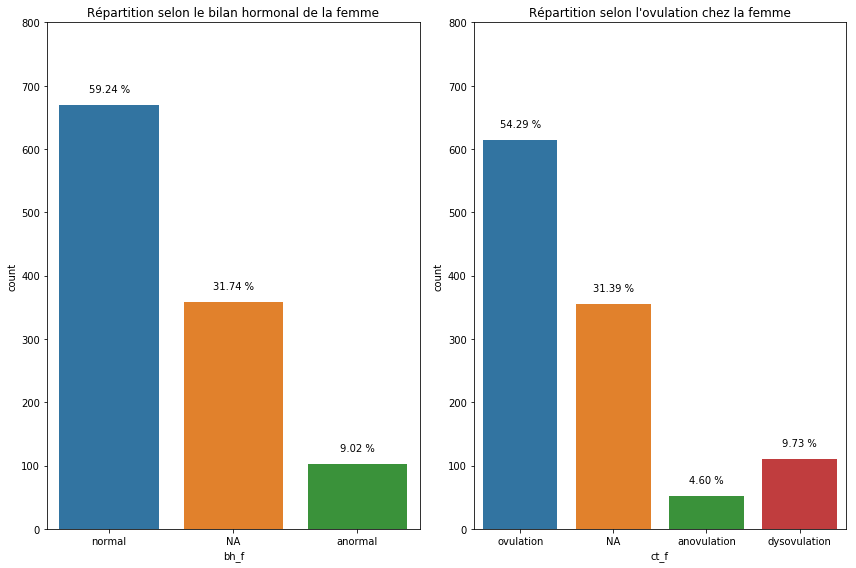

In [365]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8))
barplot_percentage('bh_f', data, 'Répartition selon le bilan hormonal de la femme', ax = axs[0])
barplot_percentage('ct_f', data, 'Répartition selon l\'ovulation chez la femme', ax = axs[1])
fig.tight_layout()

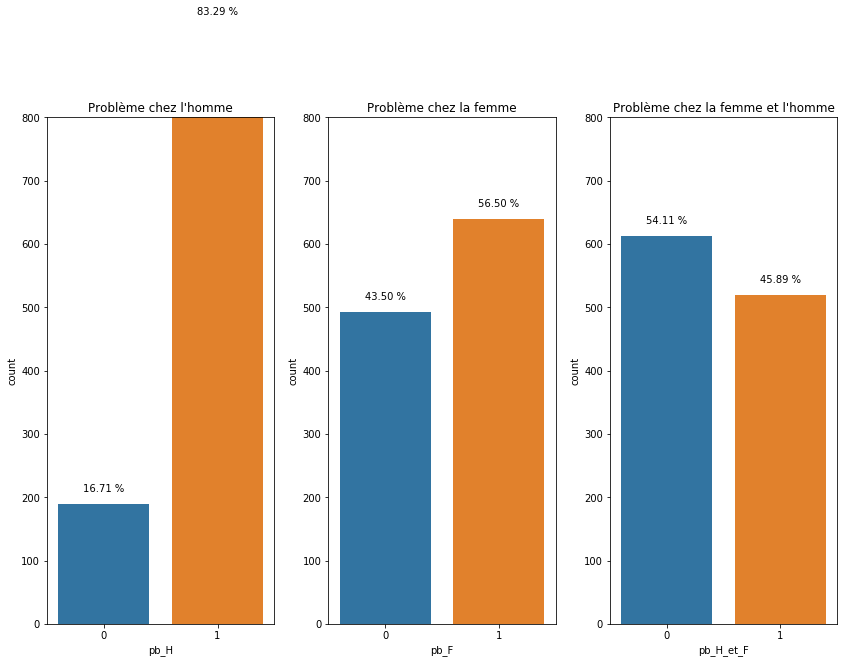

In [366]:
#On a pas pris en compte les nan
fig, axs = plt.subplots(ncols=3, figsize=(12,8))
barplot_percentage('pb_H', data, 'Problème chez l\'homme', ax = axs[0])
barplot_percentage('pb_F', data, 'Problème chez la femme', ax = axs[1])
barplot_percentage('pb_H_et_F', data, 'Problème chez la femme et l\'homme', ax = axs[2])


fig.tight_layout()

Il y a un problème chez l'homme 83% du temps contre 37% chez la femme et 32% du temps, il y a un problème chez les deux

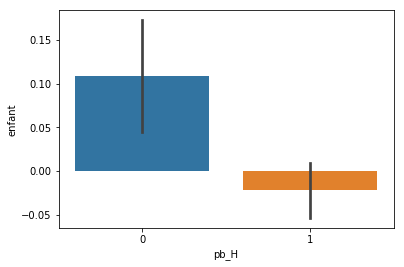

In [367]:
sns.barplot(data.pb_H, data.enfant - data.enfant.mean())

Boxplot pour variables continues

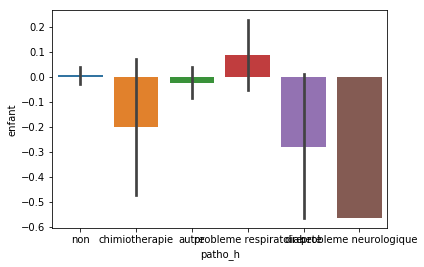

In [368]:
sns.barplot(data.patho_h, data.enfant - data.enfant.mean())

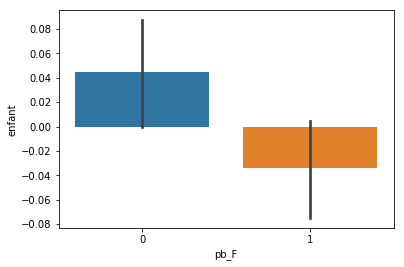

In [369]:
sns.barplot(data.pb_F, data.enfant - data.enfant.mean())

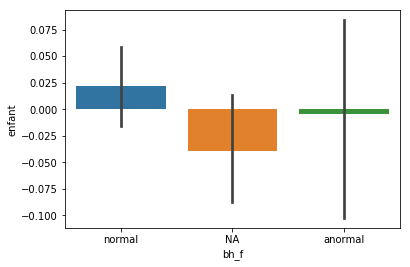

In [370]:
sns.barplot(data.bh_f, data.enfant - data.enfant.mean())

In [371]:
data.columns


Index(['id', 'enfant', 'dconsultation', 'dconception', 'ddn', 'age_h',
       'diplome_h', 'bmi_h', 'patho_h', 'cryptorchidie', 'spermo', 'age_f',
       'diplome_f', 'bh_f', 'ct_f', 'patho_f', 'fecondite',
       'duree_infertilite', 'traitement', 'tranche_age_h', 'tranche_age_f',
       'tranche_bmi_h', 'tranche_duree_infertilite', 'delta_consult_concep',
       'delta_consult_ddn', 'duree_totale_du_programme', 'isPathoH',
       'isPathoF', 'pb_F', 'pb_H', 'pb_H_et_F'],
      dtype='object')

In [372]:
data.dtypes


id                                    int64
enfant                                int64
dconsultation                datetime64[ns]
dconception                  datetime64[ns]
ddn                          datetime64[ns]
age_h                                 int64
diplome_h                            object
bmi_h                               float64
patho_h                              object
cryptorchidie                         int64
spermo                               object
age_f                               float64
diplome_f                            object
bh_f                                 object
ct_f                                 object
patho_f                              object
fecondite                            object
duree_infertilite                   float64
traitement                           object
tranche_age_h                      category
tranche_age_f                      category
tranche_bmi_h                      category
tranche_duree_infertilite       

In [373]:
data = pd.concat([
        data.select_dtypes([], ['object']),
        data.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex_axis(data.columns, axis=1)


In [374]:
data.dtypes


id                                    int64
enfant                                int64
dconsultation                datetime64[ns]
dconception                  datetime64[ns]
ddn                          datetime64[ns]
age_h                                 int64
diplome_h                          category
bmi_h                               float64
patho_h                            category
cryptorchidie                         int64
spermo                             category
age_f                               float64
diplome_f                          category
bh_f                               category
ct_f                               category
patho_f                            category
fecondite                          category
duree_infertilite                   float64
traitement                         category
tranche_age_h                      category
tranche_age_f                      category
tranche_bmi_h                      category
tranche_duree_infertilite       

REGARDER L'INFLUENCE DES TRAITEMENTS SUR LES PATHOLOGIES

In [375]:
data  = pd.get_dummies(data,drop_first=True)

In [376]:
data.columns


Index(['id', 'enfant', 'dconsultation', 'dconception', 'ddn', 'age_h', 'bmi_h',
       'cryptorchidie', 'age_f', 'duree_infertilite', 'delta_consult_concep',
       'delta_consult_ddn', 'duree_totale_du_programme', 'isPathoH',
       'isPathoF', 'pb_F', 'pb_H', 'pb_H_et_F', 'diplome_h_Bac+',
       'diplome_h_Bac-', 'patho_h_chimiotherapie', 'patho_h_diabete',
       'patho_h_non', 'patho_h_probleme neurologique',
       'patho_h_probleme respiratoire', 'spermo_azoo', 'spermo_normal',
       'diplome_f_Bac+', 'diplome_f_Bac-', 'bh_f_anormal', 'bh_f_normal',
       'ct_f_anovulation', 'ct_f_dysovulation', 'ct_f_ovulation',
       'patho_f_autre', 'patho_f_endometriose', 'patho_f_hydrosalpinx',
       'patho_f_non', 'patho_f_pb tubaire bilateral',
       'patho_f_pb tubaire unilateral', 'fecondite_secondaire',
       'traitement_FIV', 'traitement_IAC', 'traitement_IAD', 'traitement_ICSI',
       'traitement_Medical', 'tranche_age_h_30 à 40 ans',
       'tranche_age_h_40 à 50 ans', 'tranc

In [377]:
dataLogit = data[data.columns.difference(['id','dconsultation', 'dconception', 'ddn','enfant','delta_consult_concep','delta_consult_ddn','isPathoF','duree_totale_du_programme' ])]

In [378]:
dataLogit.isnull().any()

age_f                                  False
age_h                                  False
bh_f_anormal                           False
bh_f_normal                            False
bmi_h                                  False
cryptorchidie                          False
ct_f_anovulation                       False
ct_f_dysovulation                      False
ct_f_ovulation                         False
diplome_f_Bac+                         False
diplome_f_Bac-                         False
diplome_h_Bac+                         False
diplome_h_Bac-                         False
duree_infertilite                      False
fecondite_secondaire                   False
isPathoH                               False
patho_f_autre                          False
patho_f_endometriose                   False
patho_f_hydrosalpinx                   False
patho_f_non                            False
patho_f_pb tubaire bilateral           False
patho_f_pb tubaire unilateral          False
patho_h_ch

In [379]:
import statsmodels.api as sm
log = sm.Logit(data.enfant,dataLogit)
ok = log.fit()

         Current function value: 0.605504
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [380]:
table = ok.pred_table(threshold=0.5)
(table[0,0] + table[1,1]) / (table.sum())

0.67462422634836428

In [381]:
table.sum()

1131.0

In [382]:
ok.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 enfant   No. Observations:                 1131
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                           48
Date:                Tue, 30 Jan 2018   Pseudo R-squ.:                  0.1162
Time:                        14:44:26   Log-Likelihood:                -684.82
converged:                      False   LL-Null:                       -774.88
                                        LLR p-value:                 3.589e-17
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
age_f                                  -0.0551      0.030     -1.850      0.064      -0.113       0.003
age_h                                  -0.0194      0.029     -0.676      0.499      -0.076       0.037
bh_f_anormal                            0.3290      0.321      1.026      0.305      -0.299       0.957
bh_f_normal                             0.1998      0.223      0.897      0.370      -0.237       0.637
bmi_h                                   0.0230      0.038      0.601      0.548      -0.052       0.098
cryptorchidie                           0.1057      0.192      0.549      0.583      -0.272       0.483
ct_f_anovulation                       -0.3199      0.392     -0.817      0.414      -1.087       0.447
ct_f_dysovulation                      -0.0967      0.311     -0.311      0.756      -0.706       0.512
ct_f_ovulation                         -0.3433      0.218     -1.577      0.115      -0.770       0.083
diplome_f_Bac+                         -0.0423      0.184     -0.229      0.819      -0.404       0.319
diplome_f_Bac-                          0.0575      0.198      0.290      0.772      -0.331       0.446
diplome_h_Bac+                          0.5684      0.197      2.885      0.004       0.182       0.954
diplome_h_Bac-                          0.4886      0.195      2.499      0.012       0.105       0.872
duree_infertilite                      -0.0033      0.004     -0.773      0.440      -0.012       0.005
fecondite_secondaire                    0.0535      0.153      0.350      0.726      -0.246       0.353
isPathoH                              -14.8606   6790.914     -0.002      0.998   -1.33e+04    1.33e+04
patho_f_autre                          -0.2559      0.543     -0.472      0.637      -1.320       0.808
patho_f_endometriose                   -0.0831      0.552     -0.150      0.880      -1.165       0.999
patho_f_hydrosalpinx                   -0.1684      1.512     -0.111      0.911      -3.132       2.795
patho_f_non                            -0.0838      0.318     -0.263      0.792      -0.708       0.540
patho_f_pb tubaire bilateral           -0.1100      0.600     -0.183      0.855      -1.285       1.066
patho_f_pb tubaire unilateral          -0.4013      0.338     -1.189      0.234      -1.063       0.260
patho_h_chimiotherapie                 -0.9537      0.722     -1.320      0.187      -2.370       0.462
patho_h_diabete                        -1.0470      0.940     -1.114      0.265      -2.888       0.794
patho_h_non                           -14.8159   6790.914     -0.002      0.998   -1.33e+04    1.33e+04
patho_h_probleme neurologique         -11.4968    362.294     -0.032      0.975    -721.579     698.586
patho_h_probleme respiratoire           0.4574      0.385      1.187      0.235      -0.298       1.212
pb_F                                   -0.3394      0.461     -0.736      0.462      -1.243       0.564
pb_H             

In [266]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf = clf.fit(dataLogit, data.enfant)

In [263]:
clf.score(dataLogit,data.enfant)

0.96198054818744472

In [ ]:
data[data.patho_f == 'hydrosalpinx']